In [9]:
import pandas as pd
import os
from utils.find_root import find_project_root
import numpy as np
from tensorflow.keras.models import load_model
import joblib

import warnings
from sklearn.exceptions import InconsistentVersionWarning

warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

In [10]:
# Retrieve the project root dynamically and set it as working directory
project_root = find_project_root()
os.chdir(project_root)

# Define dashboard input directory
INFERENCE_OUTPUT_DIR = "outputs/modelling/inference/"

# Ensure output directory exist
os.makedirs(INFERENCE_OUTPUT_DIR, exist_ok=True)

In [11]:
# Load pre-ingested slices
df_hist = pd.read_csv("data/processed/rolling_window/baseline_rolling_1440h_until_20250531_1600.csv", parse_dates=["date"], index_col='date')
df_fcst = pd.read_csv("data/raw/forecast/forecast_72h_from_20250531_1700.csv", parse_dates=["date"], index_col='date')
# Set dates to timezone-naive
df_hist.index = df_hist.index.tz_localize(None)
df_fcst.index = df_fcst.index.tz_localize(None)

#### Step 1 – Preprocess `df_hist` and Apply Frozen Stats to the 72-Hour Forecast

**Goal**:
Prepare historical weather data (`df_hist`) for aligning the upcoming 72-hour forecast (`df_fcst`) with the anomaly detection models. This includes computing log transforms, smoothing, and freezing statistical baselines for scaling and dashboard banding — all based on the most recent 60 days of observations.

---

**Rationale**:
To maintain fair and realistic inference conditions, all transformations applied to the forecast must rely solely on historical statistics. This ensures the model never "peeks" at future data — a principle known as **temporal separation**, which is essential for avoiding data leakage and preserving the integrity of time-series anomaly detection (Tawalkuli, 2024; Trinh, 2022).

Instead of applying rolling windows to the forecast (which would require future values), we freeze the statistical baselines (mean, std, IQR, quantiles) using the latest 1440 hours of clean historical data. These "frozen stats" are then broadcasted across all 72 forecast hours to ensure consistency in scoring and visual interpretation.

---

**Visual Banding Strategy**:
We also define "normality bounds" for the dashboard, using feature-specific approaches suited to their statistical behaviour:

- **Temperature**:
  We apply `Q1` as the lower bound and `Q3 + 1.5 × IQR` as the upper bound to capture typical variation while filtering out seasonal extremes. This is a robust and interpretable method used widely in anomaly labelling (Wenig, 2022).

- **Wind Speed**:
  We use the **10th percentile** as the lower bound and `Q3 + 1.5 × IQR` for the upper, acknowledging the strong right skew in wind behaviour and to avoid overstating calm conditions (Tawalkuli, 2024).

- **Surface Pressure**:
  Since pressure is generally well-behaved and symmetric, we use `mean ± 2 × std`, a conventional method aligned with Gaussian expectations (Darban, 2024).

- **Precipitation**:
  Precipitation is highly skewed with frequent zeros, so we adopt a threshold strategy: 0.5mm (Light Rain), 2mm (ModerateRain) and 5mm (Heavy Rain) arbitrarily set and implemented in the dashboard code (not at inference).

---

All forecast rows now receive identical reference bands and scaling baselines — ensuring clarity, integrity, and robustness in downstream model scoring and dashboard display.

In [12]:
# Step 1 – Preprocess df_hist and prepare df_fcst for inference

eps = 1e-6
window_3h, min_3h = 3, 1

# ---- Step 1.1: Preprocess df_hist (frozen 1440h) ----

# Compute log1p of raw precipitation
df_hist["precip_log"] = np.log1p(df_hist["precipitation"])

# Smooth wind speed (for wind_r scaling)
df_hist["wind_smoothed"] = df_hist["wind_speed_10m"].rolling(window_3h, min_periods=min_3h).mean()

# ---- Step 1.2: Extract frozen stats for forecast z-scoring ----
stats_at_tnow = {
    # Temperature
    "temp_mean": df_hist["temperature_2m"].mean(),
    "temp_std": df_hist["temperature_2m"].std() + eps,

    # Surface pressure
    "press_mean": df_hist["surface_pressure"].mean(),
    "press_std": df_hist["surface_pressure"].std() + eps,

    # Wind (smoothed)
    "wind_median": df_hist["wind_smoothed"].median(),
    "wind_q1": df_hist["wind_smoothed"].quantile(0.25),
    "wind_q3": df_hist["wind_smoothed"].quantile(0.75),
    "wind_iqr": df_hist["wind_smoothed"].quantile(0.75) - df_hist["wind_smoothed"].quantile(0.25) + eps,

    # Precipitation (log1p)
    "precip_log_mean_12h": df_hist["precip_log"].iloc[-12:].mean(),
    "precip_log_std_12h": df_hist["precip_log"].iloc[-12:].std() + eps,
    "precip_log_mean_24h": df_hist["precip_log"].iloc[-24:].mean(),
    "precip_log_std_24h": df_hist["precip_log"].iloc[-24:].std() + eps
}

# ---- Step 1.3: Compute dashboard visualisation bounds ----

# Temperature
temp_q1 = df_hist["temperature_2m"].quantile(0.25)
temp_q3 = df_hist["temperature_2m"].quantile(0.75)
temp_upper = temp_q3 + 1.5 * (temp_q3 - temp_q1)

# Wind speed (raw)
wind_q1 = df_hist["wind_speed_10m"].quantile(0.25)
wind_q3 = df_hist["wind_speed_10m"].quantile(0.75)
wind_p10 = df_hist["wind_speed_10m"].quantile(0.10)
wind_upper = wind_q3 + 1.5 * (wind_q3 - wind_q1)

# Pressure (normal assumption)
press_mean = stats_at_tnow["press_mean"]
press_std = stats_at_tnow["press_std"]
press_lower = press_mean - 2 * press_std
press_upper = press_mean + 2 * press_std

# ---- Step 1.4: Apply transformations and broadcast bounds to df_fcst ----

# Forecast-time log1p transform
df_fcst["precip_log"] = np.log1p(df_fcst["precipitation"])

# Apply frozen z-scores and scaled features
df_fcst["temperature_2m_z"] = (df_fcst["temperature_2m"] - stats_at_tnow["temp_mean"]) / stats_at_tnow["temp_std"]
df_fcst["surface_pressure_z"] = (df_fcst["surface_pressure"] - stats_at_tnow["press_mean"]) / stats_at_tnow["press_std"]

# Wind smoothed and robust scaled
df_fcst["wind_smoothed"] = df_fcst["wind_speed_10m"].rolling(window_3h, min_periods=min_3h).mean()
df_fcst["wind_r"] = (df_fcst["wind_smoothed"] - stats_at_tnow["wind_median"]) / stats_at_tnow["wind_iqr"]

# Precip log z-scores
df_fcst["precip_z_12h"] = (df_fcst["precip_log"] - stats_at_tnow["precip_log_mean_12h"]) / stats_at_tnow["precip_log_std_12h"]
df_fcst["precip_z_24h"] = (df_fcst["precip_log"] - stats_at_tnow["precip_log_mean_24h"]) / stats_at_tnow["precip_log_std_24h"]

# Broadcast dashboard bounds (same value across all forecast hours)
df_fcst["temp_lower"] = temp_q1
df_fcst["temp_upper"] = temp_upper

df_fcst["wind_lower"] = wind_p10
df_fcst["wind_upper"] = wind_upper

df_fcst["press_lower"] = press_lower
df_fcst["press_upper"] = press_upper

# ---- Step 1.5 – Combine Preprocessed Historical and Forecast Data ----
# Ensure aligned structure and sort order before stitching
df_combined_ready = pd.concat([df_hist, df_fcst])
# Done — df_combined_ready is now the unified, model-aligned dataset for IF and LSTM-AE

#### Step 2 – LSTM Data Preprocessing

**Goal**: Prepare the unified dataset (`df_combined_ready`) for LSTM-AE inference by replicating the preprocessing steps applied during training.

This includes:

- **Cyclical feature engineering** to capture the periodic structure of time (month and hour),
- **Sliding sequence construction** using 720-hour windows with stride 1, covering both historical and forecast periods,
- **Per-sequence robust scaling** (median and IQR) of core weather features to ensure numerical stability and alignment with training-time expectations.

> Note: `precip_log` is excluded from robust scaling due to its high sparsity and non-normal distribution (Tawalkuli, 2024). Instead, it is included in raw form within each sequence as per the modelling logic.

In [13]:
# Step 2.1 – Add cyclical time features to df_combined_ready
df_combined_ready["hour"] = df_combined_ready.index.hour
df_combined_ready["month"] = df_combined_ready.index.month

# Step 2.2 Encode cyclical time features using sine and cosine
df_combined_ready["hour_sin"] = np.sin(2 * np.pi * df_combined_ready["hour"] / 24)
df_combined_ready["hour_cos"] = np.cos(2 * np.pi * df_combined_ready["hour"] / 24)
df_combined_ready["month_sin"] = np.sin(2 * np.pi * df_combined_ready["month"] / 12)
df_combined_ready["month_cos"] = np.cos(2 * np.pi * df_combined_ready["month"] / 12)

In [14]:
# Step 2.3 – Construct 720-hour LSTM-AE sequences with per-sequence robust scaling

# Define input features for LSTM-AE
# Raw precipitation is excluded in favour of unscaled precip_log
lstm_features = [
    "temperature_2m", "surface_pressure", "wind_speed_10m",
    "precip_log",  # retained in raw log-transformed form
    "hour_sin", "hour_cos", "month_sin", "month_cos"
]

# Define which features will be robustly scaled (median + IQR)
features_to_scale = ["temperature_2m", "surface_pressure", "wind_speed_10m"]
feature_indices = [lstm_features.index(f) for f in features_to_scale]

# Define a utility function to apply robust scaling per sequence
def robust_scale_sequence(seq, indices, eps=1e-5):
    seq = seq.copy()
    for i in indices:
        col = seq[:, i]
        median = np.median(col)
        iqr = np.percentile(col, 75) - np.percentile(col, 25)
        seq[:, i] = (col - median) / (iqr + eps)
    return seq

# Set window and stride
sequence_length = 720
stride = 1

# Extract raw data matrix from the combined DataFrame
raw_array = df_combined_ready[lstm_features].values
lstm_sequences = []
sequence_end_times = []

# Slide through the dataset with stride 1 to construct scaled sequences
for start in range(0, len(df_combined_ready) - sequence_length + 1, stride):
    seq = raw_array[start:start + sequence_length]
    seq_scaled = robust_scale_sequence(seq, feature_indices)
    lstm_sequences.append(seq_scaled)
    sequence_end_times.append(df_combined_ready.index[start + sequence_length - 1])

# Convert to NumPy arrays
lstm_sequences = np.stack(lstm_sequences)  # shape: [num_sequences, 720, 8]
sequence_end_times = pd.DatetimeIndex(sequence_end_times) # shape: [num_sequences]

# Save sequences as a binary .npy file
np.save(os.path.join(INFERENCE_OUTPUT_DIR,"lstm_sequences.npy"), lstm_sequences)

# Save sequence end timestamps as a CSV
sequence_end_times.to_series().to_csv(
    os.path.join(INFERENCE_OUTPUT_DIR,"sequence_end_times.csv"),
    header=["end_time"],
    index_label="sequence_idx"
)

print("✅ LSTM sequences and end times saved to outputs/modelling/inference/")

✅ LSTM sequences and end times saved to outputs/modelling/inference/


### Step 3 – Score 72-hour Forecast Using Trained IF and LSTM-AE + Assign Anomaly Labels

**Goal**: Apply both trained models to the most recent forecast window and generate timestamp-level anomaly labels. The model scores and assigned anomaly labels form the basis for interpreting anomalous behaviour over the next 72 hours.

This step includes:

- Use the trained Isolation Forest model to score the transformed 72-hour forecast slice. Apply the fixed threshold (determined during training) to label anomalies per hour.

- Use the trained LSTM-AE to compute reconstruction errors across all 720-hour sequences. Each sequence ends with a timestamp, and the final timestep of each sequence corresponds to a forecast timestamp. We compute a per-timestamp error from the final step of each sequence, then apply the pre-established 95th percentile threshold to label anomalies.

- Assign each timestamp an anomaly label based on whether it was classed as an anomaly by LSTM-AE | IF | both | none in accordance with the modelling logic.

In [15]:
# Step 3.1 – Score the 72-hour forecast using trained Isolation Forest model

# Load trained Isolation Forest model
if_model = joblib.load("outputs/modelling/models/if_model.joblib")

# Define input features (same as training)
if_features = ["temperature_2m_z", "surface_pressure_z", "wind_r", "precip_z_12h","precip_z_24h"]

# Extract forecast portion (last 72 rows)
df_fcst_ready = df_combined_ready.iloc[-72:].copy()

# Compute anomaly scores using decision_function (used during training)
df_fcst_ready["if_score"] = if_model.decision_function(df_fcst_ready[if_features])

# Apply fixed anomaly threshold derived during training (example value shown)
if_threshold = 0.03304385848702787 # ← Replace with actual saved threshold from training
df_fcst_ready["is_if_anomaly"] = (df_fcst_ready["if_score"] < if_threshold).astype(int)

In [16]:
# Step 3.2 – Compute LSTM-AE MAE per timestamp and flag anomalies using fixed threshold

# Load trained LSTM Autoencoder model
lstm_ae = load_model("outputs/modelling/models/lstm_ae_best.h5")

# Predict reconstructions from LSTM-AE
lstm_recon = lstm_ae.predict(lstm_sequences, verbose=0)  # shape: [n_seq, 720, 8]

# Compute MAE per timestep across all 8 LSTM input features
mae_seq = np.mean(np.abs(lstm_sequences - lstm_recon), axis=2)  # shape: [n_seq, 720]

# Build timestamp array per sequence
timestamps_array = sequence_end_times.values[:, None] - np.arange(sequence_length - 1, -1, -1).astype("timedelta64[h]")
flat_timestamps = timestamps_array.ravel()
flat_errors = mae_seq.ravel()

# Assemble tidy per-timestamp error dataframe
df_lstm_errors_forecast = pd.DataFrame({
    "date": pd.to_datetime(flat_timestamps),
    "lstm_error": flat_errors
})

# Aggregate overlapping timestamps by mean
df_lstm_errors_forecast_agg = (
    df_lstm_errors_forecast
    .groupby("date")["lstm_error"]
    .mean()
    .reset_index()
)

# Apply fixed threshold from retrospective scoring
lstm_threshold = 0.6425  # ← Replace with actual threshold used in training
df_lstm_errors_forecast_agg["is_lstm_anomaly"] = (df_lstm_errors_forecast_agg["lstm_error"] > lstm_threshold).astype(int)
df_lstm_errors_forecast_agg["lstm_error"].describe()

count    1512.000000
mean        0.424936
std         0.106004
min         0.170420
25%         0.349350
50%         0.412613
75%         0.482797
max         0.842720
Name: lstm_error, dtype: float64

In [17]:
# Step 3.3 – Safely merge LSTM-AE per-timestamp scores with forecast features

df_fcst_ready = df_fcst_ready.merge(
    df_lstm_errors_forecast_agg,
    how="left",
    left_index=True,
    right_on="date"
).set_index("date")

In [18]:
# Step 3.4 – Broadcast fixed thresholds for visibility and debugging
df_fcst_ready["if_threshold"] = if_threshold
df_fcst_ready["lstm_threshold"] = lstm_threshold

In [19]:
# Step 3.5 – Assign anomaly labels based on hybrid model outputs

def assign_anomaly_label(row):
    if row["is_if_anomaly"] == 1 and row["is_lstm_anomaly"] == 1:
        return "Compound anomaly"
    elif row["is_if_anomaly"] == 1:
        return "Point anomaly"
    elif row["is_lstm_anomaly"] == 1:
        return "Pattern anomaly"
    else:
        return "Normal"

# Apply to forecast-ready dataframe
df_fcst_ready["anomaly_label"] = df_fcst_ready.apply(assign_anomaly_label, axis=1)

In [20]:
# Count occurrences
value_counts = df_fcst_ready["anomaly_label"].value_counts()

# Compute proportions
proportions = df_fcst_ready["anomaly_label"].value_counts(normalize=True) * 100  # Convert to percentage

# Combine into a DataFrame
summary_df = pd.DataFrame({"Count": value_counts, "Proportion (%)": proportions})

print(summary_df)

                  Count  Proportion (%)
anomaly_label                          
Normal               58       80.555556
Compound anomaly      9       12.500000
Pattern anomaly       5        6.944444


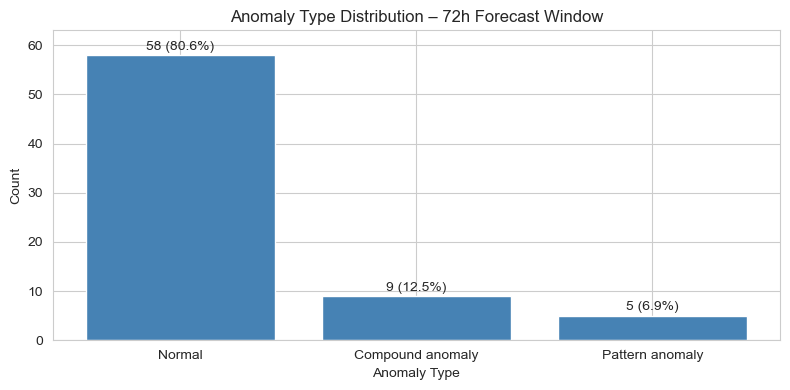

In [24]:
# Count and proportion of each anomaly type
value_counts = df_fcst_ready["anomaly_label"].value_counts()
proportions = df_fcst_ready["anomaly_label"].value_counts(normalize=True) * 100
summary_df = pd.DataFrame({"Count": value_counts, "Proportion (%)": proportions})

# Plot
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 4))
bars = ax.bar(summary_df.index, summary_df["Count"], color="steelblue")

for bar, count, pct in zip(bars, summary_df["Count"], summary_df["Proportion (%)"]):
    ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5,
            f"{count} ({pct:.1f}%)", ha="center", va="bottom", fontsize=10)

ax.set_xlabel("Anomaly Type")
ax.set_ylabel("Count")
ax.set_title("Anomaly Type Distribution – 72h Forecast Window")
ax.set_ylim(0, max(summary_df["Count"]) + 5)
plt.tight_layout()
plt.show()

In [479]:
subset = ['temperature_2m', 'surface_pressure', 'precipitation', 'wind_speed_10m','temp_lower', 'temp_upper',
       'wind_lower', 'wind_upper', 'press_lower', 'press_upper','if_score', 'is_if_anomaly', 'lstm_error',
       'is_lstm_anomaly', 'if_threshold', 'lstm_threshold', 'anomaly_label']
df_dashboard_ready = df_fcst_ready[subset]

In [480]:
# Extract forecast timestamp from df_fcst filename
fcst_filename = os.path.basename("data/raw/forecast/forecast_72h_from_20250531_1700.csv")
fcst_tag = fcst_filename.replace("forecast_72h_from_", "").replace(".csv", "")

# Define output file paths
inference_output_path = os.path.join(INFERENCE_OUTPUT_DIR, f"inference_{fcst_tag}.csv")
dashboard_output_path = os.path.join(INFERENCE_OUTPUT_DIR, f"dashboard_input_{fcst_tag}.csv")

# Save outputs
df_fcst_ready.to_csv(inference_output_path, index=True)
df_dashboard_ready.to_csv(dashboard_output_path, index=True)